In [3]:
import sim
import numpy as np
import sympy as sp
import pandas as pd
import time
import threading as thr
import keyboard


def connect(port):
# Establece la conexión a CoppeliaSim
# port debe coincidir con el puerto de conexión en VREP
# retorna el número de cliente o -1 si no puede establecer conexión
    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) # Conectarse
    if clientID == 0: print("conectado a", port)
    else: print("no se pudo conectar")
    return clientID

# Conectarse al servidor de VREP
# *** ejecutar cada vez que se reinicia la simulación ***
clientID = connect(19999)

retCode,Dummy=sim.simxGetObjectHandle(clientID,'Dummy',sim.simx_opmode_blocking)
retCode,Largo_point=sim.simxGetObjectHandle(clientID,'Largo',sim.simx_opmode_blocking)
retCode,joint1=sim.simxGetObjectHandle(clientID,'joint1',sim.simx_opmode_blocking)
retCode,joint2=sim.simxGetObjectHandle(clientID,'joint2',sim.simx_opmode_blocking)

retCode,muslo1=sim.simxGetObjectHandle(clientID,'muslo1',sim.simx_opmode_blocking)
retCode,rodilla1=sim.simxGetObjectHandle(clientID,'rodilla1',sim.simx_opmode_blocking)

retCode,muslo2=sim.simxGetObjectHandle(clientID,'muslo2',sim.simx_opmode_blocking)
retCode,rodilla2=sim.simxGetObjectHandle(clientID,'rodilla2',sim.simx_opmode_blocking)

retCode,muslo3=sim.simxGetObjectHandle(clientID,'muslo3',sim.simx_opmode_blocking)
retCode,rodilla3=sim.simxGetObjectHandle(clientID,'rodilla3',sim.simx_opmode_blocking)

retCode,muslo4=sim.simxGetObjectHandle(clientID,'muslo4',sim.simx_opmode_blocking)
retCode,rodilla4=sim.simxGetObjectHandle(clientID,'rodilla4',sim.simx_opmode_blocking)

Run = True

no se pudo conectar


In [4]:
#import numpy as np
#import matplotlib.pyplot as plt
#import sympy as sp
#import pandas as pd

#-------------------------------------------------------------------------
#
#                       Funciones de la trayectoria
#
#-------------------------------------------------------------------------

def symTfromDH(theta, d, a, alpha):
    # theta y alpha en radianes
    # d y a en metros
    Rz = sp.Matrix([[sp.cos(theta), -sp.sin(theta), 0, 0],
                   [sp.sin(theta), sp.cos(theta), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    tz = sp.Matrix([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, d],
                   [0, 0, 0, 1]])
    ta = sp.Matrix([[1, 0, 0, a],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    Rx = sp.Matrix([[1, 0, 0, 0],
                   [0, sp.cos(alpha), -sp.sin(alpha), 0],
                   [0, sp.sin(alpha), sp.cos(alpha), 0],
                   [0, 0, 0, 1]])
    T = Rz*tz*ta*Rx
    return T



def find_intersection_points(center, radius, line_slope, line_intercept):
    a = 1 + line_slope**2
    b = -2 * center[0] + 2 * line_slope * (line_intercept - center[1])
    c = center[0]**2 + (line_intercept - center[1])**2 - radius**2

    discriminant = b**2 - 4*a*c

    if discriminant < 0:
        return []  # No intersection points

    x1 = (-b + np.sqrt(discriminant)) / (2*a)
    x2 = (-b - np.sqrt(discriminant)) / (2*a)
    y1 = line_slope * x1 + line_intercept
    y2 = line_slope * x2 + line_intercept

    return [(x1, y1), (x2, y2)]

def create_oval_through_points(point1, point2, altura, frames):
    x1, y1 = point1
    x2, y2 = point2
    
    # Calcular el ancho y la altura utilizando los puntos dados
    if x1 > x2:
        width = x1*2
    elif x1 < x2:
        width = x2*2
    height = altura/2
    
    # Calcular el centro del óvalo
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    
    # Generar el óvalo utilizando las dimensiones calculadas
    theta = np.linspace(0, 2 * np.pi, frames)
    x = center_x + width/2 * np.cos(theta)
    y = center_y + height/2 * np.sin(theta)
    
    return x, y


# Descripción de Denavit-Hartenberg (a = largo de la extremidad (en metros))
#      theta     |      d      |      a      |    alpha
# ----------------------------------------------------------
#       q1             0             0.2            0
#       q2             0             0.2            0


def Get_Value(mov_x,mov_y,largo_extremidad):
    #largo_extremidad = 0.2
    q1 = sp.symbols('q1')
    q2 = sp.symbols('q2')

    T = sp.simplify(symTfromDH(q1, 0, largo_extremidad, 0)* symTfromDH(q2, 0, largo_extremidad, 0))
    
    df = pd.DataFrame(columns=['Muslo', 'Rodilla','PosX','PosY','Largo_Extremidades(m)'])
    
    if len(mov_x) != len(mov_y):
        return print("Dimensiones de mov_x y mov_y no coinsiden",len(mov_x) ,len(mov_y))
    
    for i in range(len(mov_y)):
        a=mov_y[i]
        b=mov_x[i]
        # definimos las ecuaciones a resolver
        ec1, ec2 = T[3]-a, T[7]-b
        (ec1, ec2)
        # ahora resolvemos la ecuación utilizando nsolve()
        try:
            q = sp.nsolve((ec1, ec2),(q1,q2),(1,-1), prec=6)
            df.loc[len(df)] = {'Muslo': q[0], 'Rodilla': q[1],'PosX': b,'PosY': a,'Largo_Extremidades(m)':largo_extremidad}
        except:
            #print(a,b)
            #print("no se pudo calcular")
            q = [0, 0, 0]
            
    filtro_1 = df['Muslo'] <= -3.5 # Borrar
    filtro_2 = df['Muslo'] >= 3.5 # Borrar

    df2 = df.drop(df[filtro_1].index)
    df2 = df2.drop(df[filtro_2].index)
    
    filtro_3 = df2['Rodilla'] <= -3 # Borrar
    
    df2 = df2.drop(df2[filtro_3].index)
    
    # Limpieza del primer y último dato para evitar comportamiento extraño
    df2 = df2.drop([0, len(df2)-1])
    
    return df2


#-------------------------------------------------------------------------
#
#                       Parametrización
#
#------------------------------------------------------------------------

# Descripción de Denavit-Hartenberg (a = largo de la extremidad (en metros))
#      theta     |      d      |      a      |    alpha
# ----------------------------------------------------------
#       q1             0             0.2            0
#       q2             0             0.2            0

def Get_Mov(largo_extremidad, altura_actual, Frames):
    # Parámetros de la circunferencia y la recta
    center = (0, 0)
    radius = largo_extremidad * 2
    line_slope = 0
    #altura_actual = 0.3

    # Encontrar puntos de intersección
    intersection_points = find_intersection_points(center, radius, line_slope, altura_actual)

    # Puntos que definen el óvalo
    point1 = intersection_points[0]
    point2 = intersection_points[1]

    # Crear el óvalo que pasa por los puntos dados
    #                                               , altura)
    x, y = create_oval_through_points(point1, point2, altura_actual, Frames)

    mov_x = []
    mov_y = []
    
    # Filtracion de datos
    for i in range(len(y)):
        if y[i] <= altura_actual: # Si es menor que la distancia del robot al piso se puede elevar la pata
            mov_x.append(x[i])
            mov_y.append(y[i])

    #--------------------------------------------------------
    #
    #       aGREGAR EL ARRASTE, LA LINEA RECTA
    #
    #--------------------------------------------------------

    
    mitad = len(mov_y) // 2
    aux1 = [altura_actual for i in range(len(mov_y))]
    mov_y = aux1[mitad:] + mov_y + aux1[:mitad]
    aux1 = np.linspace(mov_x[len(mov_x)-1], mov_x[1], len(mov_x))
    aux2 = aux1[:mitad]
    aux3 = aux1[mitad:]
    mov_x = np.concatenate((aux3,mov_x))
    mov_x = np.concatenate((mov_x,aux2))

    return Get_Value(mov_x,mov_y,largo_extremidad)

def Pierna_Delantera_Izquierda(df, velocidad):
    while Run:
        for index, row in df.iterrows():
            retCode = sim.simxSetJointTargetPosition(clientID, muslo1, row['Muslo'], sim.simx_opmode_oneshot)
            retCode = sim.simxSetJointTargetPosition(clientID, rodilla1, row['Rodilla'], sim.simx_opmode_oneshot)
            time.sleep(velocidad) #delay entre cada movimiento ejemplo: 0.001

def Pierna_Delantera_Derecha(df, velocidad):
    while Run:
        for index, row in df.iterrows():
            retCode = sim.simxSetJointTargetPosition(clientID, muslo4, row['Muslo'], sim.simx_opmode_oneshot)
            retCode = sim.simxSetJointTargetPosition(clientID, rodilla4, row['Rodilla'], sim.simx_opmode_oneshot)
            time.sleep(velocidad) #delay entre cada movimiento ejemplo: 0.001
    
def Pierna_Tracera_Izquierda(df, velocidad):
    while Run:
        for index, row in df.iterrows():
            retCode = sim.simxSetJointTargetPosition(clientID, muslo2, row['Muslo'], sim.simx_opmode_oneshot)
            retCode = sim.simxSetJointTargetPosition(clientID, rodilla2, row['Rodilla'], sim.simx_opmode_oneshot)
            time.sleep(velocidad) #delay entre cada movimiento ejemplo: 0.001
        
def Pierna_Tracera_Derecha(df, velocidad):
    while Run:
        for index, row in df.iterrows():
            retCode = sim.simxSetJointTargetPosition(clientID, muslo3, row['Muslo'], sim.simx_opmode_oneshot)
            retCode = sim.simxSetJointTargetPosition(clientID, rodilla3, row['Rodilla'], sim.simx_opmode_oneshot)
            time.sleep(velocidad) #delay entre cada movimiento ejemplo: 0.001

def esperar_input(time_stop):
    global Run
    while not keyboard.is_pressed('w'):
        pass
    time.sleep(time_stop)
    Run = False
    
def MovimientoTotal(orden, delay_mov, delay_hilo,time_stop):
    global Run
    Run = True
    funciones = [Pierna_Delantera_Izquierda, Pierna_Tracera_Izquierda, Pierna_Delantera_Derecha, Pierna_Tracera_Derecha]
    hilos = []
    for i in range(4):
        hilo = thr.Thread(target=funciones[i], args=(orden,delay_mov))
        hilos.append(hilo)

    hilo_1 = thr.Thread(target=esperar_input, args=(time_stop,))
    hilo_1.start()
    # Iniciar los hilos
    for hilo in hilos:
        hilo.start()
        time.sleep(delay_hilo)

    hilo_1.join(timeout=0.01)

        # Esperar a que los hilos terminen
    for hilo in hilos:
        hilo.join(timeout=0.01)

In [9]:

# Verificar el Run = True
# Get_Mov (largo de cada extremidad , distancia del torso al suelo, frames para los movimientos)
retroceso = Get_Mov(0.2,0.3,400) # levanta y arrastra
avance = retroceso[::-1] # arrastra y levanta

# Movimiento Vertical
mov_x2 = [0.0 for i in range(100)]
mov_y2 = np.linspace(0.1, 0.4, 100)

mov_to_down = Get_Value(mov_x2,mov_y2,0.2) # Descenso
mov_to_up = mov_to_down[::-1]

In [ ]:
print(retroceso.iloc[200])

In [10]:
# (orden, delay_mov, delay_hilo,time_stop)
MovimientoTotal(retroceso, 0.001, 0.25, 1)

<function matplotlib.pyplot.show(close=None, block=None)>

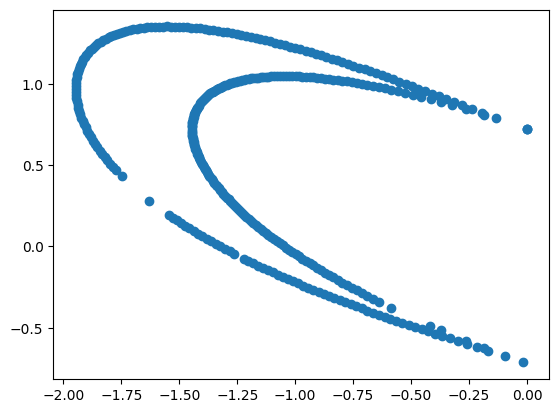

In [29]:
import matplotlib.pyplot as plt

plt.scatter(x=avance['Rodilla'], y=avance['Muslo'])
plt.show

In [18]:
import keyboard
import time

def tu_funcion():
    print("La tecla 'w' está siendo presionada.")

while True:
    if keyboard.is_pressed('w'):
        while keyboard.is_pressed('w'):
            MovimientoTotal(retroceso, 0.001, 0.25, 10)
            break
    if keyboard.is_pressed('p'):
        break  # Sale del bucle cuando se presiona la tecla 'p'

In [3]:
# Get_Mov(largo del brazo y de la rodilla 0.2, altura del piso 0.3, datos400)
#retroceso = Get_Mov(0.2,0.3,400) # levanta y arrastra
#avance = retroceso[::-1] # arrastra y levanta
import pandas as pd
import numpy as np

# Definir las funciones Get_Mov(), retroceso y avance aquí

# Crear listas para almacenar los DataFrames
retroceso_dfs = []
avance_dfs = []

#Número de iteraciones
num_iteraciones = 10  # Puedes ajustar este valor según tu necesidad

largo_extremi = [0.2 , 0.21 , 0.22 , 0.23 , 0.24 , 0.25 , 0.26 , 0.27 , 0.28 , 0.29, 0.30]

for long in (largo_extremi):
    alturas = np.linspace(0.1, largo_extremi, 10)
    for altu in range(len(alturas)):
        try:
            retroceso_df = Get_Mov(long, alturas[altu][0], 1000)  # Llama a Get_Mov() con tus parámetros
        except:
            pass
        avance_df = retroceso_df[::-1]  # Invierte el DataFrame para avance

        retroceso_dfs.append(retroceso_df)
        avance_dfs.append(avance_df)
        
#Concatenar DataFrames dentro de las listas
retroceso_final = pd.concat(retroceso_dfs, ignore_index=True)
avance_final = pd.concat(avance_dfs, ignore_index=True)

# Guardar DataFrames en archivos CSV
retroceso_final.to_csv('retroceso_data.csv', index=False)
avance_final.to_csv('avance_data.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np

# Definir las funciones Get_Mov(), retroceso y avance aquí

# Crear listas para almacenar los DataFrames
retroceso_dfs = []
avance_dfs = []

#Número de iteraciones
num_iteraciones = 10  # Puedes ajustar este valor según tu necesidad

largo_extremi = [0.18 , 0.19 , 0.20 , 0.21, 0.22]

for long in (largo_extremi):
    for x in range(10):
        alturas = np.linspace(0.15, largo_extremi, x)
        for altu in range(len(alturas)):
            try:
                retroceso_df = Get_Mov(long, alturas[altu][0], 600)  # Llama a Get_Mov() con tus parámetros
            except:
                pass
            avance_df = retroceso_df[::-1]  # Invierte el DataFrame para avance

            retroceso_dfs.append(retroceso_df)
            avance_dfs.append(avance_df)

#Concatenar DataFrames dentro de las listas
retroceso_final = pd.concat(retroceso_dfs, ignore_index=True)
avance_final = pd.concat(avance_dfs, ignore_index=True)

# Escribir en archivos CSV en modo 'append' para agregar al final
retroceso_final.to_csv('retroceso_data.csv', index=False, mode='a', header=False)
avance_final.to_csv('avance_data.csv', index=False, mode='a', header=False)

In [ ]:
#Concatenar DataFrames dentro de las listas
retroceso_final = pd.concat(retroceso_dfs, ignore_index=True)
avance_final = pd.concat(avance_dfs, ignore_index=True)

# Escribir en archivos CSV en modo 'append' para agregar al final
retroceso_final.to_csv('retroceso_data.csv', index=False, mode='a', header=False)
avance_final.to_csv('avance_data.csv', index=False, mode='a', header=False)

##### OBTENER DATOS DE ENTRENAMIENTO

         Muslo    Rodilla      PosX      PosY  Largo_Extremidades(m)
0      1.95403  -0.572689  0.381913 -0.037121                    0.2
2      1.46346   -2.83503  0.002805  0.061009                    0.2
3      1.55731   -1.02029  0.302297  0.174544                    0.2
4      2.53654   -2.78957  0.063694  0.029137                    0.2
5      2.61217   -1.43842  0.285449 -0.095279                    0.2
...        ...        ...       ...       ...                    ...
13438  2.87133   -1.52493  0.248383 -0.148236                    0.2
13439  1.47130   -2.57537  0.020401  0.109859                    0.2
13442  2.99779   -2.60202  0.105765 -0.013395                    0.2
13443  1.58735   -2.91656  0.005780  0.044537                    0.2
13444  1.24230   -2.17469  0.028696  0.183707                    0.2

[10789 rows x 5 columns]


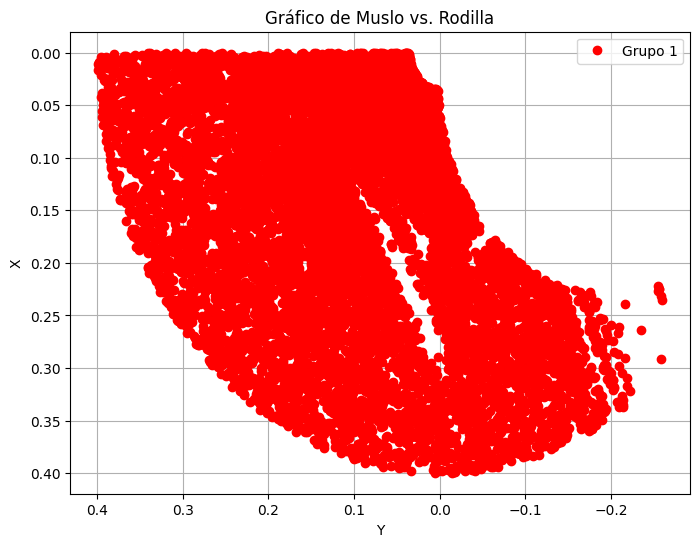

In [18]:
import random
import math
import matplotlib.pyplot as plt
import pandas as pd

# Definir el radio de la pierna (longitud)
radio_pierna = 0.4

# Generar puntos aleatorios dentro del semicírculo
puntos_dentro_semicirculo = []

x_centro = 0
y_centro = -0.2

for _ in range(20000):  # Puedes ajustar la cantidad de puntos que deseas generar
    # Generar un ángulo aleatorio en el rango [-90°, 90°]
    angulo = random.uniform(-math.pi / 2, math.pi / 2)

    # Generar una distancia aleatoria dentro del rango [0, radio_pierna]
    distancia = random.uniform(0, radio_pierna)

    # Calcular las coordenadas (x, y) del punto
    x = distancia * math.cos(angulo)
    y = distancia * math.sin(angulo)

    # Asegurarse de que x no sea menor que 0.0
    x = max(0.0, x)

    # Agregar el punto a la lista
    distancia_al_centro = np.sqrt((x - x_centro)**2 + (y - y_centro)**2)
    if distancia_al_centro >= 0.199999:
        puntos_dentro_semicirculo.append((x, y))

# Extraer las coordenadas x e y de los puntos
coord_x, coord_y = zip(*puntos_dentro_semicirculo)

q1 = sp.symbols('q1')
q2 = sp.symbols('q2')

mov_x = coord_x
mov_y = coord_y
    
T = sp.simplify(symTfromDH(q1, 0, 0.2, 0)* symTfromDH(q2, 0, 0.2, 0))
    
df = pd.DataFrame(columns=['Muslo', 'Rodilla','PosX','PosY','Largo_Extremidades(m)'])
    
if len(mov_x) != len(mov_y):
    print("Dimensiones de mov_x y mov_y no coinsiden",len(mov_x) ,len(mov_y))
    
for i in range(len(mov_y)):
    a=mov_y[i]
    b=mov_x[i]
    # definimos las ecuaciones a resolver
    ec1, ec2 = T[3]-a, T[7]-b
    (ec1, ec2)
    # ahora resolvemos la ecuación utilizando nsolve()
    try:
        q = sp.nsolve((ec1, ec2),(q1,q2),(1,-1), prec=6)
        df.loc[len(df)] = {'Muslo': q[0], 'Rodilla': q[1],'PosX': b,'PosY': a,'Largo_Extremidades(m)':0.2}
    except:
        #print(a,b)
        #print("no se pudo calcular")
        q = [0, 0, 0]
            
#filtro_1 = df['Muslo'] <= -3.5 # Borrar
#filtro_2 = df['Muslo'] >= 3.5 # Borrar
#
#df2 = df.drop(df[filtro_1].index)
#df2 = df2.drop(df[filtro_2].index)
#    
#filtro_3 = df2['Rodilla'] <= -3 # Borrar
#    
#df2 = df2.drop(df2[filtro_3].index)

filtro_muslo = (df['Muslo'] >= -1.5708) & (df['Muslo'] <= 3) # Agregamos 90° (1.5) + para mapear la mayor zona posible
filtro_rodilla = (df['Rodilla'] >= -2.96706) & (df['Rodilla'] <= 0)

# Aplicar los filtros y obtener el DataFrame filtrado
df_filtrado = df.loc[filtro_muslo & filtro_rodilla]

print(df_filtrado)
#Para agregar sin sobreescribir
df_filtrado.to_csv('datos_entrenamiento.csv', mode='a', header=False, index=False)

plt.figure(figsize=(8, 6))  # Tamaño del gráfico
plt.plot(df_filtrado['PosY'], df_filtrado['PosX'], 'ro', label='Grupo 1')  # Grupo 1 en rojo ('ro')
plt.xlabel('Y')  # Etiqueta eje X
plt.ylabel('X')  # Etiqueta eje Y
plt.title('Gráfico de Muslo vs. Rodilla')  # Título del gráfico
plt.legend()  # Mostrar leyenda
plt.gca().invert_xaxis()  # Invertir eje X
plt.gca().invert_yaxis()  # Invertir eje Y
# Muestra el gráfico
plt.grid(True)  # Agregar cuadrícula
plt.show()

In [184]:
filtro_muslo = (df['Muslo'] >= -1.5708) & (df['Muslo'] <= 1.5708)

filtro_rodilla = (df['Rodilla'] >= -2.96706) & (df['Rodilla'] <= 0)

df_filtrado2 = df.loc[filtro_muslo & filtro_rodilla]

df_filtrado2.to_csv('datos_entrenamiento.csv', index=False)

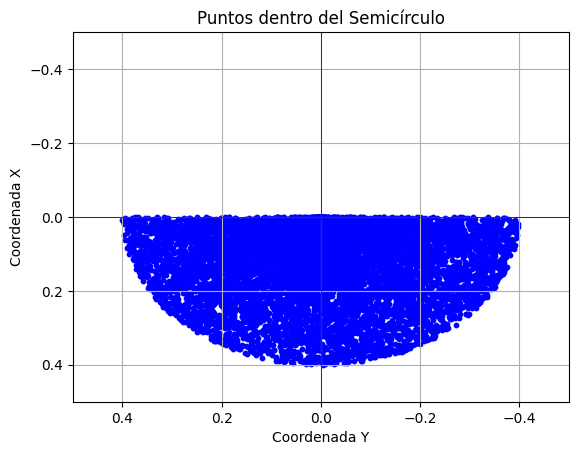

In [122]:
import random
import math
import matplotlib.pyplot as plt

# Definir el radio de la pierna (longitud)
radio_pierna = 0.4

# Generar puntos aleatorios dentro del semicírculo
puntos_dentro_semicirculo = []

for _ in range(10000):  # Puedes ajustar la cantidad de puntos que deseas generar
    # Generar un ángulo aleatorio en el rango [-90°, 90°]
    angulo = random.uniform(-math.pi / 2, math.pi / 2)

    # Generar una distancia aleatoria dentro del rango [0, radio_pierna]
    distancia = random.uniform(0, radio_pierna)

    # Calcular las coordenadas (x, y) del punto
    x = distancia * math.cos(angulo)
    y = distancia * math.sin(angulo)

    # Asegurarse de que x no sea menor que 0.0
    x = max(0.0, x)

    # Agregar el punto a la lista
    puntos_dentro_semicirculo.append((x, y))

# Extraer las coordenadas x e y de los puntos
coord_x, coord_y = zip(*puntos_dentro_semicirculo)

# Graficar los puntos dentro del semicírculo
plt.scatter(coord_y, coord_x, s=10, color='blue')  # Invertir ejes
plt.xlabel('Coordenada Y')  # Etiqueta eje Y
plt.ylabel('Coordenada X')  # Etiqueta eje X
plt.title('Puntos dentro del Semicírculo')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)  # Línea horizontal en y=0
plt.axvline(0, color='black', linewidth=0.5)  # Línea vertical en x=0
plt.xlim(-0.5, 0.5)  # Limitar el rango en x a [-1, 1]
plt.ylim(-0.5, 0.5)  # Limitar el rango en y a [-1, 1]
plt.gca().invert_xaxis()  # Invertir eje X
plt.gca().invert_yaxis()  # Invertir eje Y

# Mostrar el gráfico
plt.show()

In [136]:
import pandas as pd
import sympy as sp

q1 = sp.symbols('q1')
q2 = sp.symbols('q2')

mov_x = coord_x
mov_y = coord_y
    
T = sp.simplify(symTfromDH(q1, 0, 0.2, 0)* symTfromDH(q2, 0, 0.2, 0))
    
df = pd.DataFrame(columns=['Muslo', 'Rodilla','PosX','PosY','Largo_Extremidades(m)'])
    
if len(mov_x) != len(mov_y):
    print("Dimensiones de mov_x y mov_y no coinsiden",len(mov_x) ,len(mov_y))
    
for i in range(len(mov_y)):
    a=mov_y[i]
    b=mov_x[i]
    # definimos las ecuaciones a resolver
    ec1, ec2 = T[3]-a, T[7]-b
    (ec1, ec2)
    # ahora resolvemos la ecuación utilizando nsolve()
    try:
        q = sp.nsolve((ec1, ec2),(q1,q2),(1,-1), prec=6)
        df.loc[len(df)] = {'Muslo': q[0], 'Rodilla': q[1],'PosX': b,'PosY': a,'Largo_Extremidades(m)':0.2}
    except:
        #print(a,b)
        #print("no se pudo calcular")
        q = [0, 0, 0]
            
#filtro_1 = df['Muslo'] <= -3.5 # Borrar
#filtro_2 = df['Muslo'] >= 3.5 # Borrar
#
#df2 = df.drop(df[filtro_1].index)
#df2 = df2.drop(df[filtro_2].index)
#    
#filtro_3 = df2['Rodilla'] <= -3 # Borrar
#    
#df2 = df2.drop(df2[filtro_3].index)

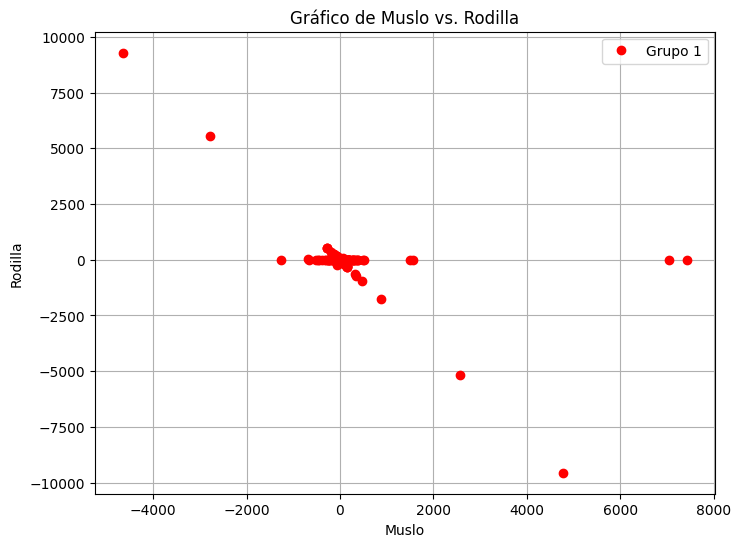

In [42]:
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt


# Divide los datos en dos grupos basados en algún criterio
# Por ejemplo, si quieres dividirlos en dos grupos por la mitad del DataFrame:
mitad = len(df) // 2
grupo1 = df2.iloc[:mitad]
grupo2 = df2.iloc[mitad:]

# Crea el gráfico con dos colores diferentes
plt.figure(figsize=(8, 6))  # Tamaño del gráfico
plt.plot(df['Muslo'], df['Rodilla'], 'ro', label='Grupo 1')  # Grupo 1 en rojo ('ro')
plt.xlabel('Muslo')  # Etiqueta eje X
plt.ylabel('Rodilla')  # Etiqueta eje Y
plt.title('Gráfico de Muslo vs. Rodilla')  # Título del gráfico
plt.legend()  # Mostrar leyenda

# Muestra el gráfico
plt.grid(True)  # Agregar cuadrícula
plt.show()

In [68]:
# Filtro para las filas donde 'Muslo' está en el rango [0, 4]
filtro_muslo = (df2['Muslo'] >= -3) & (df2['Muslo'] <= 3)

# Filtro para las filas donde 'Rodilla' está en el rango [-1, 0.5]
filtro_rodilla = (df2['Rodilla'] >= -1) & (df2['Rodilla'] <= 0.5)

# Aplicar los filtros y obtener el DataFrame filtrado
df_filtrado = df2.loc[filtro_muslo & filtro_rodilla]

print(len(df_filtrado))

816


In [178]:
# Filtro para las filas donde 'Muslo' está en el rango [0, 4]
#filtro_muslo = (df['Muslo'] >= -1.5708) & (df['Muslo'] <= 1.5708)
filtro_muslo = (df['Muslo'] >= -1.5708)

# Filtro para las filas donde 'Rodilla' está en el rango [-1, 0.5]
#filtro_rodilla = (df['Rodilla'] >= -2.96706) & (df['Rodilla'] <= 0)
filtro_rodilla = (df['Rodilla'] >= -2.96706)

# Aplicar los filtros y obtener el DataFrame filtrado
df_filtrado = df.loc[filtro_muslo & filtro_rodilla]
print(len(df_filtrado))

5832


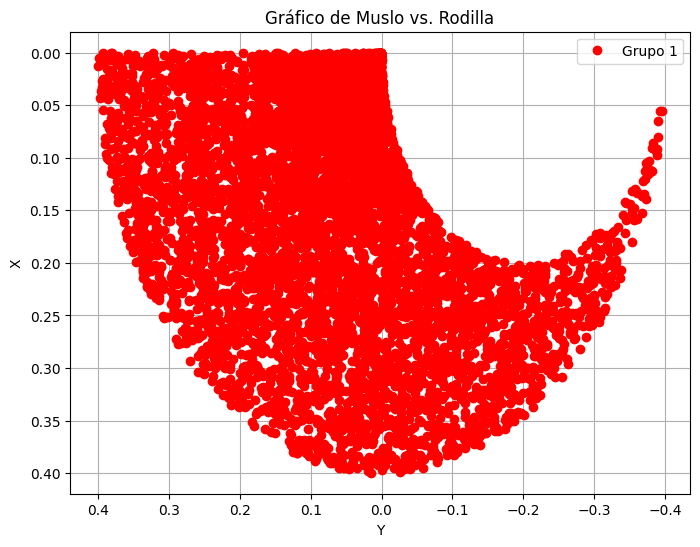

In [177]:
plt.figure(figsize=(8, 6))  # Tamaño del gráfico
plt.plot(df['PosY'], df['PosX'], 'ro', label='Grupo 1')  # Grupo 1 en rojo ('ro')
plt.xlabel('Y')  # Etiqueta eje X
plt.ylabel('X')  # Etiqueta eje Y
plt.title('Gráfico de Muslo vs. Rodilla')  # Título del gráfico
plt.legend()  # Mostrar leyenda
plt.gca().invert_xaxis()  # Invertir eje X
plt.gca().invert_yaxis()  # Invertir eje Y
# Muestra el gráfico
plt.grid(True)  # Agregar cuadrícula
plt.show()

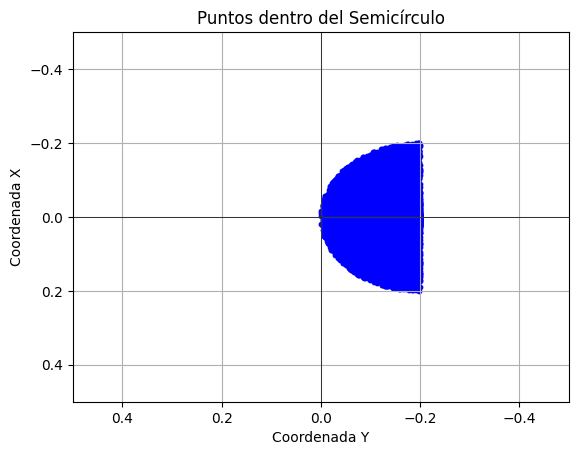

In [121]:
# Graficar los puntos dentro del semicírculo
plt.scatter(coord_y, coord_x, s=10, color='blue')  # Invertir ejes
plt.xlabel('Coordenada Y')  # Etiqueta eje Y
plt.ylabel('Coordenada X')  # Etiqueta eje X
plt.title('Puntos dentro del Semicírculo')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)  # Línea horizontal en y=0
plt.axvline(0, color='black', linewidth=0.5)  # Línea vertical en x=0
plt.xlim(-0.5, 0.5)  # Limitar el rango en x a [-1, 1]
plt.ylim(-0.5, 0.5)  # Limitar el rango en y a [-1, 1]
plt.gca().invert_xaxis()  # Invertir eje X
plt.gca().invert_yaxis()  # Invertir eje Y

# Mostrar el gráfico
plt.show()

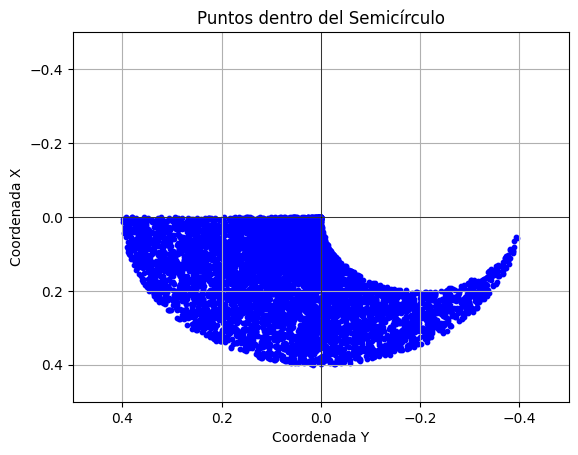

In [135]:
import random
import math
import matplotlib.pyplot as plt

# Definir el radio de la pierna (longitud)
radio_pierna = 0.4

# Generar puntos aleatorios dentro del semicírculo
puntos_dentro_semicirculo = []

x_centro = 0
y_centro = -0.2

for _ in range(10000):  # Puedes ajustar la cantidad de puntos que deseas generar
    # Generar un ángulo aleatorio en el rango [-90°, 90°]
    angulo = random.uniform(-math.pi / 2, math.pi / 2)

    # Generar una distancia aleatoria dentro del rango [0, radio_pierna]
    distancia = random.uniform(0, radio_pierna)

    # Calcular las coordenadas (x, y) del punto
    x = distancia * math.cos(angulo)
    y = distancia * math.sin(angulo)

    # Asegurarse de que x no sea menor que 0.0
    x = max(0.0, x)

    # Agregar el punto a la lista
    distancia_al_centro = np.sqrt((x - x_centro)**2 + (y - y_centro)**2)
    if distancia_al_centro >= 0.199999:
        puntos_dentro_semicirculo.append((x, y))

# Extraer las coordenadas x e y de los puntos
coord_x, coord_y = zip(*puntos_dentro_semicirculo)

# Graficar los puntos dentro del semicírculo
plt.scatter(coord_y, coord_x, s=10, color='blue')  # Invertir ejes
plt.xlabel('Coordenada Y')  # Etiqueta eje Y
plt.ylabel('Coordenada X')  # Etiqueta eje X
plt.title('Puntos dentro del Semicírculo')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)  # Línea horizontal en y=0
plt.axvline(0, color='black', linewidth=0.5)  # Línea vertical en x=0
plt.xlim(-0.5, 0.5)  # Limitar el rango en x a [-1, 1]
plt.ylim(-0.5, 0.5)  # Limitar el rango en y a [-1, 1]
plt.gca().invert_xaxis()  # Invertir eje X
plt.gca().invert_yaxis()  # Invertir eje Y

# Mostrar el gráfico
plt.show()

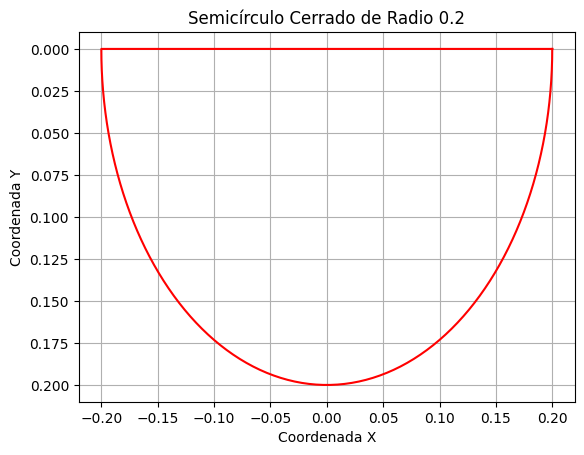

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# Definir el radio del semicírculo
radio_semicirculo = 0.2

# Generar valores de ángulo (theta) en el rango [0, pi]
theta = np.linspace(0, np.pi, 100)

# Calcular las coordenadas (x, y) de los puntos en el semicírculo cerrado
x = radio_semicirculo * np.cos(theta)
y = radio_semicirculo * np.sin(theta)

# Agregar el punto final para cerrar el semicírculo
x = np.append(x, x[0])
y = np.append(y, y[0])

# Graficar el semicírculo cerrado
plt.plot(x, y, color='red')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Semicírculo Cerrado de Radio 0.2')
plt.grid(True)
plt.gca().invert_yaxis()  # Invertir eje Y para que esté hacia arriba
plt.show()

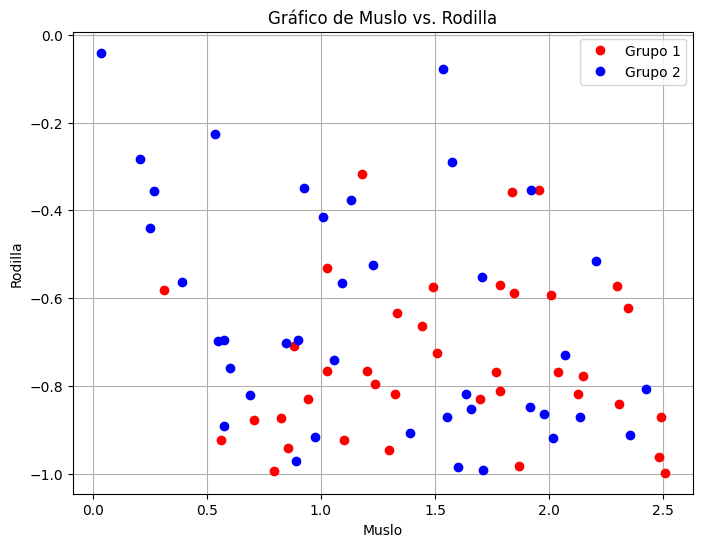

In [12]:
mitad = len(df_filtrado) // 2
grupo1 = df_filtrado.iloc[:mitad]
grupo2 = df_filtrado.iloc[mitad:]

# Crea el gráfico con dos colores diferentes
plt.figure(figsize=(8, 6))  # Tamaño del gráfico
plt.plot(grupo1['Muslo'], grupo1['Rodilla'], 'ro', label='Grupo 1')  # Grupo 1 en rojo ('ro')
plt.plot(grupo2['Muslo'], grupo2['Rodilla'], 'bo', label='Grupo 2')  # Grupo 2 en azul ('bo')
plt.xlabel('Muslo')  # Etiqueta eje X
plt.ylabel('Rodilla')  # Etiqueta eje Y
plt.title('Gráfico de Muslo vs. Rodilla')  # Título del gráfico
plt.legend()  # Mostrar leyenda

# Muestra el gráfico
plt.grid(True)  # Agregar cuadrícula
plt.show()

In [26]:
# Guardar el DataFrame filtrado en un archivo CSV
#df_filtrado.to_csv('datos_entrenamiento.csv', index=False)

In [ ]:
# Obtener el identificador del joint 'muslo1' y la esfera 'Sphere'
_, muslo1_handle = sim.simxGetObjectHandle(cliente_id, 'muslo1', sim.simx_opmode_blocking)
_, sphere_handle = sim.simxGetObjectHandle(cliente_id, 'Sphere', sim.simx_opmode_blocking)

# Obtener la posición del joint 'muslo1' y la esfera 'Sphere'
_, muslo1_position = sim.simxGetObjectPosition(cliente_id, muslo1_handle, -1, sim.simx_opmode_blocking)
_, sphere_position = sim.simxGetObjectPosition(cliente_id, sphere_handle, -1, sim.simx_opmode_blocking)

# Calcular la distancia en el eje Z entre 'muslo1' y 'Sphere'
distancia_z = abs(muslo1_position[2] - sphere_position[2])

print(f"Distancia en el eje Z entre 'muslo1' y 'Sphere': {distancia_z}")

In [29]:
sim.simxFinish(-1)

In [3]:
import sim

# Conectar a CoppeliaSim
sim.simxFinish(-1)  # Cerrar todas las conexiones existentes
cliente_id = sim.simxStart('127.0.0.1', 19997, True, True, 5000, 5)  # Conectar al servidor de CoppeliaSim

if cliente_id != -1:
    print("Conexión exitosa a CoppeliaSim")
    
    # Obtener el identificador del joint 'mulo1' y el Dummy 'Largo'
    _, mulo1_handle = sim.simxGetObjectHandle(cliente_id, 'muslo1', sim.simx_opmode_blocking)
    _, largo_handle = sim.simxGetObjectHandle(cliente_id, 'Largo', sim.simx_opmode_blocking)

    # Obtener la posición del joint 'mulo1' y el Dummy 'Largo'
    _, mulo1_position = sim.simxGetObjectPosition(cliente_id, mulo1_handle, -1, sim.simx_opmode_blocking)
    _, largo_position = sim.simxGetObjectPosition(cliente_id, largo_handle, -1, sim.simx_opmode_blocking)

    # Calcular la distancia en el eje Z entre 'mulo1' y 'Largo'
    distancia_z = abs(mulo1_position[2] - largo_position[2])
    
    
    print(mulo1_position)
    print(largo_position)
    print(f"Distancia en el eje Z entre 'mulo1' y 'Largo': {distancia_z}")

    # Desconectar de CoppeliaSim
    sim.simxFinish(cliente_id)
else:
    print("No se pudo conectar a CoppeliaSim")

Conexión exitosa a CoppeliaSim
[-0.2000003606081009, 0.40000009536743164, 0.42500045895576477]
[-0.17500999569892883, 0.4000000059604645, 0.02500000037252903]
Distancia en el eje Z entre 'mulo1' y 'Largo': 0.40000045858323574


In [ ]:
numero_redondeado = round(numero, 3)
print(numero_redondeado)